In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Library**

In [2]:
!pip install transformers
!pip install underthesea
!pip install datasets evaluate transformers rouge-score nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 

In [3]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

**get data**

In [5]:
link_data = "/content/drive/MyDrive/largeProject/code/predictIntent/data2/"

In [7]:
import os

os.listdir(link_data)

['groupMonthOverall.pkl',
 'oneKPI.pkl',
 'crossView.pkl',
 'ChildInferenceMom.pkl',
 'viewStat.pkl',
 'groupMonthDetail.pkl',
 'viewDetermineTrend.pkl',
 'viewPredict.pkl',
 'viewExplainResult.pkl',
 'viewOneKPIStat.pkl',
 'viewCtyDescribe.pkl',
 'viewOneGroupKPIStat.pkl',
 'childQuestion.pkl']

In [8]:
l2i = {ele.split('.')[0] : i for i,ele in enumerate(os.listdir(link_data)) if ele.split('.')[0] != 'childQuestion'}
i2l = {i : ele.split('.')[0] for i,ele in enumerate(os.listdir(link_data)) if ele.split('.')[0] != 'childQuestion'}

In [9]:
df = pd.read_csv("/content/drive/MyDrive/largeProject/code/predictIntent/intent_5000_past.csv")

In [10]:
df.dropna(inplace=True)

In [11]:
texts = df['text'].to_list()
labels = df['label'].to_list()

In [ ]:
!pip install py_vncorenlp

import py_vncorenlp

py_vncorenlp.download_model(save_dir='/content/')
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/')

In [ ]:
from tqdm import tqdm

texts = [rdrsegmenter.word_segment(text)[0] for text in tqdm(texts)]

100%|██████████| 64882/64882 [01:50<00:00, 587.12it/s] 


**Train/val/test**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) # 0.25 x 0.8 = 0.2

In [14]:
train_df = pd.DataFrame({
    "text" : X_train,
    "label" : y_train
})

val_df = pd.DataFrame({
    "text" : X_val,
    "label" : y_val
})

test_df = pd.DataFrame({
    "text" : X_test,
    "label" : y_test
})

In [ ]:
train_df = pd.concat([train_df, val_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

<Axes: xlabel='label', ylabel='count'>

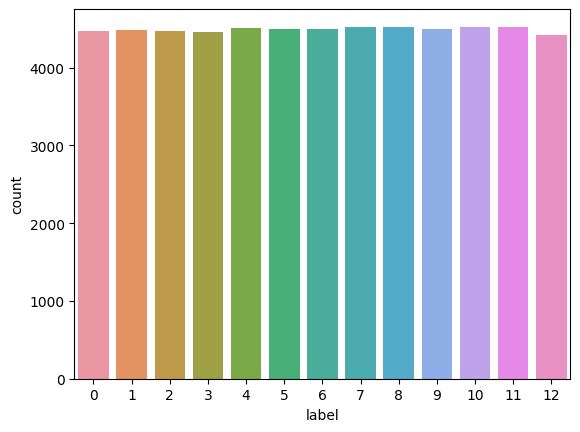

In [ ]:
sns.countplot(x='label', data=train_df)

**Data Loader**

In [15]:
model_checkpoint = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['text']
        text = ' '.join(simple_preprocess(text))
        label = row['label']

        return text, label

In [17]:
simple_preprocess(train_df.text.to_list()[0])

['trong',
 'quý',
 'bắt_đầu',
 'đến',
 'hết',
 'tháng',
 'hãy',
 'giúp',
 'hiểu',
 'hơn',
 'về',
 'do',
 'cụm',
 'chỉ_tiêu',
 'tiến_độ',
 'xử_lý',
 'phản_ánh',
 'của',
 'kh',
 'bo',
 'có',
 'trung_bình',
 'như_thế_nào']

In [18]:
train_df.dropna(inplace=True)

In [19]:
test_df.dropna(inplace=True)

In [20]:
val_df.dropna(inplace=True)

Text(0.5, 9.444444444444438, 'Token Count')

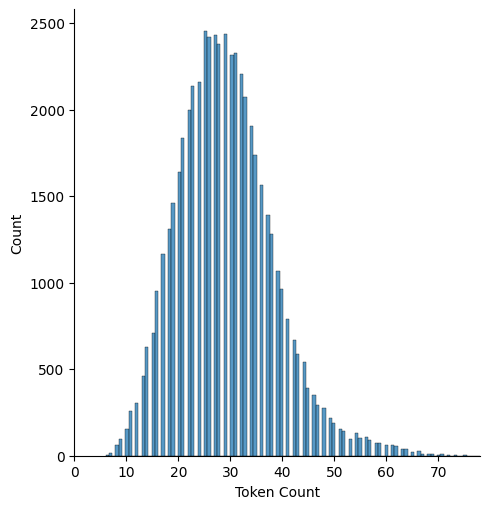

In [21]:
all_data = train_df.text.tolist() + val_df.text.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**Classification**

In [22]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_checkpoint)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

**train & eval function**

In [23]:
from tqdm import tqdm

In [24]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in tqdm(train_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(model, criterion, optimizer, valid_loader, test_loader=None, test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in tqdm(data_loader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

**Prepare training**

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [25]:
model = SentimentClassifier(n_classes=13).to(device)

In [26]:
train_dataset = SentimentDataset(train_df, tokenizer, max_len=120)
valid_dataset = SentimentDataset(val_df, tokenizer, max_len=120)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
# Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
# Batchsize: 16, 32
optimizer = AdamW(model.parameters(), lr=2e-5)

lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader)*EPOCHS
        )
best_acc = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    train(model, criterion, optimizer, train_loader)
    val_acc = eval(model, criterion, optimizer, valid_loader, None)

    if val_acc > best_acc:
        torch.save(model.state_dict(), f'/content/phobert_fold1.pth')
        best_acc = val_acc

Epoch 1/6
------------------------------


100%|██████████| 760/760 [14:14<00:00,  1.12s/it]


Train Accuracy: 0.9340329218106996 Loss: 0.32476289099033334


100%|██████████| 85/85 [00:31<00:00,  2.74it/s]


Valid Accuracy: 1.0 Loss: 0.006023227226208238
Epoch 2/6
------------------------------


100%|██████████| 760/760 [14:11<00:00,  1.12s/it]


Train Accuracy: 1.0 Loss: 0.005066558940789515


100%|██████████| 85/85 [00:31<00:00,  2.74it/s]


Valid Accuracy: 1.0 Loss: 0.00189876430804896
Epoch 3/6
------------------------------


100%|██████████| 760/760 [14:11<00:00,  1.12s/it]


Train Accuracy: 0.9999176954732512 Loss: 0.0025565456854804466


100%|██████████| 85/85 [00:30<00:00,  2.74it/s]


Valid Accuracy: 1.0 Loss: 0.000993928307092146
Epoch 4/6
------------------------------


100%|██████████| 760/760 [14:12<00:00,  1.12s/it]


Train Accuracy: 1.0 Loss: 0.0012714333543523313


100%|██████████| 85/85 [00:31<00:00,  2.74it/s]


Valid Accuracy: 1.0 Loss: 0.0006425124949173016
Epoch 5/6
------------------------------


 79%|███████▊  | 598/760 [11:12<03:02,  1.12s/it]


KeyboardInterrupt: ignored

In [ ]:
# for fold in range(skf.n_splits):
#     print(f'-----------Fold: {fold+1} ------------------')
#     train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
#     model = SentimentClassifier(n_classes=13).to(device)
#     criterion = nn.CrossEntropyLoss()
#     # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
#     # Batchsize: 16, 32
#     optimizer = AdamW(model.parameters(), lr=2e-5)

#     lr_scheduler = get_linear_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps=0,
#                 num_training_steps=len(train_loader)*EPOCHS
#             )
#     best_acc = 0
#     for epoch in range(EPOCHS):
#         print(f'Epoch {epoch+1}/{EPOCHS}')
#         print('-'*30)

#         train(model, criterion, optimizer, train_loader)
#         val_acc = eval(model, criterion, optimizer, valid_loader, None)

#         if val_acc > best_acc:
#             torch.save(model.state_dict(), f'/content/phobert_fold{fold+1}.pth')
#             best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------


100%|██████████| 2920/2920 [17:26<00:00,  2.79it/s]


Train Accuracy: 0.9659202808579869 Loss: 0.153943871977629


100%|██████████| 730/730 [01:19<00:00,  9.16it/s]


Valid Accuracy: 0.9999143688987839 Loss: 0.0012568110421902743
Epoch 2/6
------------------------------


100%|██████████| 2920/2920 [17:26<00:00,  2.79it/s]


Train Accuracy: 0.9994648285310613 Loss: 0.0036063843481091156


100%|██████████| 730/730 [01:19<00:00,  9.17it/s]


Valid Accuracy: 0.9999143688987839 Loss: 0.0007959562674828977
Epoch 3/6
------------------------------


100%|██████████| 2920/2920 [17:27<00:00,  2.79it/s]


Train Accuracy: 0.9996146765423641 Loss: 0.00242736673148575


100%|██████████| 730/730 [01:19<00:00,  9.16it/s]


Valid Accuracy: 0.9999999999999999 Loss: 8.04082970168802e-05
Epoch 4/6
------------------------------


 18%|█▊        | 534/2920 [03:12<14:18,  2.78it/s]


KeyboardInterrupt: ignored

**Test**

In [27]:
def test(data_loader):
    models = []
    for fold in range(1):
        model = SentimentClassifier(n_classes=13)
        model.to(device)
        model.load_state_dict(torch.load(f'/content/phobert_fold1.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [28]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=120)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       484
           3       1.00      1.00      1.00       495
           4       1.00      1.00      1.00       495
           5       1.00      1.00      1.00       504
           6       1.00      1.00      1.00       460
           7       1.00      1.00      1.00       551
           8       1.00      1.00      1.00       470
           9       1.00      1.00      1.00       512
          10       1.00      1.00      1.00       484
          11       1.00      1.00      1.00       510

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



**Correlation**

<Axes: >

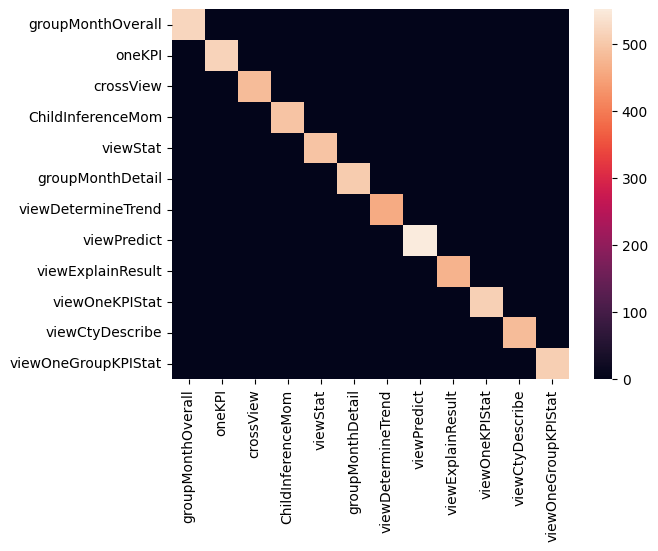

In [29]:
class_names = l2i.keys()
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].text)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------


IndexError: ignored

**Inference**

In [ ]:
def infer_intent(text, max_len=32, top_k=4, verbose=True):
    model.eval()
    text = rdrsegmenter.word_segment(text)[0]
    print(text)
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    # print(output)
    topk_output = torch.topk(output,top_k)[1][0].cpu().numpy()
    # print(topk_output)

    _, y_pred = torch.max(output, dim=1)

    pred = y_pred[0].cpu().numpy()
    if verbose == True:
      print(f'Text: {text}')
      print(f'Sentiment: {i2l[int(pred)]}')

    return i2l[int(pred)],topk_output

In [ ]:
infer_intent("giá trị lớn nhất cụm chỉ tiêu Giao tiền nhanh (trong 2 giờ) có kết quả ra sao trong quý 1")

giá_trị lớn nhất cụm chỉ_tiêu Giao tiền nhanh ( trong 2 giờ ) có kết_quả ra sao trong quý 1
Text: giá_trị lớn nhất cụm chỉ_tiêu Giao tiền nhanh ( trong 2 giờ ) có kết_quả ra sao trong quý 1
Sentiment: viewOneGroupKPIStat


('viewOneGroupKPIStat', array([11, 12,  6,  4]))

In [ ]:
i2l

{0: 'groupMonthOverall',
 1: 'oneKPI',
 2: 'crossView',
 3: 'ChildInferenceMom',
 4: 'viewStat',
 5: 'groupMonthDetail',
 6: 'viewDetermineTrend',
 7: 'viewPredict',
 8: 'viewExplainResult',
 9: 'viewOneKPIStat',
 10: 'viewCtyDescribe',
 11: 'viewOneGroupKPIStat',
 12: 'childQuestion'}

In [ ]:
train_df

,text,label,kfold
0,Tôi muốn biết chỉ_tiêu mẹ của chỉ_tiêu con Xử_...,3,0.0
1,Cho hỏi chỉ_tiêu Tổng_đài 19009095 có được kết...,1,0.0
2,"Tháng 1 , năm 2022 thông_tin tường_minh hơn về...",5,0.0
3,Có nhiễu_động nào khi so_sánh của kết_quả quý ...,2,0.0
4,"Trong quý 4 , năm 2020 bắt_đầu đến hết tháng 1...",1,0.0
...,...,...,...
58400,Trong khoảng thời_gian từ năm 2020 tính đến th...,9,4.0
58401,Tôi có một vấn_đề cần được giải_đáp_liệu cả th...,2,4.0
58402,Phân_tích tóm_tắt của cụm chỉ_tiêu Tỷ_lệ kết_n...,0,4.0
58403,Có_thể cho tui biết của tổng_công_ty VTT với c...,7,4.0


**Save model**

In [ ]:
model.load_state_dict(torch.load('/content/phobert_fold1.pth'))

# tokenizer.push_to_hub("hoangphu7122002ai/phobert_predictIntent",commit_message=f"Training done")
# model.push_to_hub("hoangphu7122002ai/phobert_predictIntent",commit_message=f"Training done")

<All keys matched successfully>

In [30]:
import shutil
shutil.copy('/content/phobert_fold1.pth', '/content/drive/MyDrive/largeProject/code/predictIntent/phobert_fold_latest.pth')

'/content/drive/MyDrive/largeProject/code/predictIntent/phobert_fold_latest.pth'